# Integer Muliplication using Karatsuba method

This project is part 1 of implementing different algorithms for integer manipulation. The aim is to build code that can handle multiplication (and add/subtract) in any base, from binary through decimal to 'base 1,000,000' and above. It will also handle long integers - 10s of thousands of digits or 'limbs' long.

The final version of the class can be also found in the [bigbaseinteger.py file](), which includes unit tests.

It turns out that multiplication using the algorithm we learned in school (shift across, multiply each digit, carry over, etc) is not the most efficient, especially when dealing with very large integers - such as those used in cryptography.

Optimising the 'big-O' complexity has seen a lot of research and small improvements big by bit, finally reaching an optimal(?) version in 2019, even if that solution (currently) only works for unusably large numbers:
- **Long multiplication** -> $\mathcal{O}(n^{2})$ -> The way taught in primary school
- **1960: Karatsuba** -> $\mathcal{O}(n^{1.58})$ -> Faster than 'school' multiplication when $n$ is $2^{320}$ or $\sim10^{96}$
- **1963: Toom-Cook-Knuth** -> $\mathcal{O}(n⋅2^{\sqrt{2 \log n}}\log n)$ -> Generalization of Karatsuba.
- **1971: Schönhage-Strassen** -> $\mathcal{O}(n \log n \log \log n)$ -> Faster above $\sim10^{10,000}$
- **2007: Fürer** -> $\mathcal{O}(n \log n⋅2^{\mathcal{O}(log^∗ n)})$ -> Faster above $\sim10^{1,000,000,000,000,000,000}$
- **2019: Harvey & van der Hoeven** -> $\mathcal{O}(n \log n)$ -> Faster above $\sim10^{10^{38}}$ or $2^{1729^{12}}$

The initial focus is on the ['Karatsuba Multiplication Algorithm'](https://en.wikipedia.org/wiki/Karatsuba_algorithm).

First, the algorithm is tested out in Python integers. Then, a ```BaseInteger``` class will be developed that will take in different representations and build up to addition, multiplication and subtraction. Various operators, such as +, \*, - will be added. This could be extended with implementing powers and division, and also conversion between different bases.

Finally, some refactoring to improve performance. As we are implementing in Python, we are at a disadvantage in general compared to - for example, writing this in optimised C or C++, but it is useful to see how the algorithms work and what improvements can be made.

[Part 2](link tbc) will look at Fast Fourier Transforms, which are the basis of the Schönhage-Strassen methods and other further improvements.

## Initial Algorithm
Although the 'long multiplication' algorithm that is taught in schools works well, a faster algorithm - at least for larger integers - can be implemented with a 'divide and conquer' approach. We split each of the numbers into two, so that:
\begin{align}
x \times  y &= (x_{1} \times  10^{n} + x_{0}) \times (y_{1} \times  10^{n} + y_{0}) \\
& = x_{1}y_{1} \times  10^{2n} + (x_{1}y_{0} + x_{0}y_{1}) \times 10^{n}) + x_{0}y_{0} \\
& = z_{2} \times  10^{2n} + z_{1} \times 10^{n} + z_{0} \\
\end{align}
where
$z_{2} = x_{1}y_{1}$ and $z_{1} = x_{1}y_{0} + x_{0}y_{1}$ and $z_{0} = x_{0}y_{0}$
which uses 4 multiplications and offers no real advantage over the 'school' method.

However, Karatsuba further recognised that these 4 multiplications could be reduced to 3 multiplications and some additions, which would be faster for larger numbers, by using $z_{1} = (x_{1} + x_{0})(y_{1} + y_{0}) - z_{2} - z_{0}$. This way, we can 'win' the race with recursion.

Note that these are all shown in base 10, but it is extendable to any base.

### Splitting at 'n/2'
The first implementation of the algorithm using Python modular division. The ```split_at``` function will help to do the split the number at a given number of digits. e.g. 123987 split at 3 digits will give 123 and 987

In [1]:
def split_at(num,digits):
    return (num//digits, num % digits)

In [2]:
import math
print(split_at(123456,10**3))
print(split_at(123456,10**4))
print (math.log10(1_234_567_890)//2+1)
print(split_at(1_234_567_890,10**(math.ceil(math.log10(1_234_567_890))//2)))

(123, 456)
(12, 3456)
5.0
(12345, 67890)


### Initial version of Karatsuba
Now, here's a first implementation, using log10 from the Python math library to find the best split point for now. Later, this will be replaced, but for now it gives a quick way to find 'n/2', where n is the number of digits.

In [3]:
def RecursiveIntegerMultiply(x, y):
    # If one is under 10, this is the base case:
    if (x < 10) or (y < 10):
        return x * y

    # Find the number of (base 10) digits:
    m = int(math.log10(max(x,y))//2+1)
    split_mult = 10**m
    
    high_x,low_x = split_at(x,split_mult)
    high_y,low_y = split_at(y,split_mult)

    z2 = RecursiveIntegerMultiply(high_x,high_y)
    z1 = RecursiveIntegerMultiply(high_x+low_x, high_y+low_y)
    z0 = RecursiveIntegerMultiply(low_x,low_y)

    return z2*(split_mult**2)+(z1-z2-z0)*split_mult+z0

In [4]:
print(RecursiveIntegerMultiply(1000,1000))

1000000


In [5]:
for x,y in (123456789,987654321), \
           (123456789123456789123456789123456789,987654321987654321987654321), \
           (987654321987654321987654321123456789123456789123456789123, \
            987654321987654321987654321123456789123456789123456789123):
    print("Python:  ",x*y)
    print("Function:",RecursiveIntegerMultiply(x,y), end='\n\n')


Python:   121932631112635269
Function: 121932631112635269

Python:   121932631356500531591068431703703700581771069347203169112635269
Function: 121932631356500531591068431703703700581771069347203169112635269

Python:   975461059740893159506325257564700502268404202972107904421746680684042979980339279277425090639992990874560891109129
Function: 975461059740893159506325257564700502268404202972107904421746680684042979980339279277425090639992990874560891109129



## Implementation of BaseInteger class with add() for addition
This class will implement the ```add()``` method for addition, as well as initialising with a number as a string. Representing a number as a string means we can easily add different bases (e.g. hex) later. The ```__str__``` method ensures the number can be printed easily.

Internally, the design uses an integer array, with the digits in reverse order - so '125' is stored as \[5, 2, 1\]. This makes addition and carry over easier, as if we carry over to a higher digit, it can be added easily. The array used is a numpy array set to be ```np.int8``` - but we will need to increase that to make sure there is no overflow once numbers become bigger. Although this implementation will not be 'blazing fast', at least this gives a fast underlying mechanism as numpy is fast and uses fixed areas in memory for the numbers. It also allows for easy implementation of the 'split_at' function and a 'shift' left/right function later.

In [6]:
import numpy as np
class BaseInteger():
    def __init__ (self, x):
        x = x.lstrip('0')
        if len(x) < 1: x = '0'
        self._number = np.zeros(len(x), dtype=np.int8)
        i = 0
        for digit in reversed(x):
            self._number[i] = int(digit)
            i += 1

    def __str__ (self):
        return ''.join(map(str,reversed(self._number.tolist())))
        
    def add (self, other):
        shorter,longer = self._number, other._number
        if len(shorter)>len(longer):
            longer,shorter = shorter,longer

        result = np.zeros(len(longer)+1,dtype=np.int8)
        carry = 0
        for digit in range(len(shorter)):
            add = shorter[digit]+longer[digit]+carry
            result[digit]=add%10
            carry = add//10
        for digit in range(len(shorter),len(longer)):
            add = longer[digit]+carry
            result[digit]=add%10
            carry = add//10
        if carry > 0:
            result[digit]=carry
            
        return BaseInteger(''.join(map(str,reversed(result))))


In [7]:
# Some simple testing. We'll do a lot more below.
for test1, test2 in ('51231235234', '0'), ('51231235234', '51231235234'):
    int1 = BaseInteger(test1)
    int2 = BaseInteger(test2)
    res = int1.add(int2)
    print (int1, '+', int2, '=', res)

51231235234 + 0 = 51231235234
51231235234 + 51231235234 = 12462470468


## Implementing multiply() and adding support for different bases
The first implementation of the multiply. Note that this is not Karatsuba, as there isn't a subtract method to use! Still, the code checks for this and uses the longer, 4-multiplication mechanism otherwise.

Bases are implemented up to base 36. This is chosen, because the digits 0-9 plus letters A-Z allow 36 unique digits. Everything is changed to upper case. Note that multiplying/adding between bases works if the target bases get 'smaller', but the algorithm doesn't correctly deal with 'carryunder' yet - when the bases get larger and so need adjusting for higher digits to be represented correctly.

The constructor also adds support for string, numpy arrays and integers to be passed in. We'll change to ```np.int16``` for the internal number storage array here.

### Adding infix operators
The functions to do this are listed in the [Python 3 documentation on emulating numeric types](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types)

In [8]:
import numpy as np

class BaseInteger():
    def __init__ (self, x, base=10):
        self._base = base
        if isinstance(x,(np.ndarray,)):
            self._number = x.copy()
            # In case we copy a zero-length array, add one digit (a zero)
            # This was an error found during testing with random numbers (speed test)
            if len(x) < 1:
                self._number = np.zeros(1, dtype=np.int16)
        elif isinstance(x,(int)):
            self._number = np.asarray((x,),dtype=np.int16)
        else:
            if len(x) < 1:
                self._number = np.zeros(1, dtype=np.int16)
            elif (base <= 10): # string assumed!
                self._number = np.array(list(map(int,reversed(x))), dtype=np.int16)
            else: # could have characters in there.
                self._number = np.array(list(map(lambda x: (ord(x) - 48) if 48 <=ord(x)<=57 else ord(x)-65+10,reversed(x.upper()))), dtype=np.int16)

        # Calculate any carryovers
        if len(self._number) > 0:
            self._number = self.propogate_carryovers(self._number,base)
        else:
            print ('empty init', self._number, base, x)
            raise Exception("Zero length")

        # Clean up any leading zeros:
        while len(self._number) > 1 and self._number[-1] == 0:
            self._number = np.delete(self._number, -1)
        # And a sanity check that all digits are less than the base number
        assert (self._number[self._number[:] >= base].sum() == 0), "Overflow - digit out of range."

    def __str__ (self):
        if (self._base <= 10):
            return ''.join(map(str,reversed(self._number.tolist())))
        else:
            return ''.join(map(lambda x: str(x) if x < 10 else chr(65+x-10), reversed(self._number.tolist())))
        
    def get_longer_shorter(self,x,y):
        if len(x)>len(y):
            return x,y
        return y,x

    def propogate_carryovers(self,result,base):
        # Calculate any carryovers
        for digit in range(0,len(result)-1):
            result[digit+1] += result[digit]//base
            result[digit] %= self._base

        while result[-1]>=self._base:
            result = np.append(result, [result[-1]//self._base])
            result[-2] %= self._base

        return result

    def shift (self, shift_num):
        result = BaseInteger(self._number,self._base)
        if shift_num == 0:
            return result
        elif shift_num > 0:
            result._number = np.append(np.zeros(shift_num, dtype=np.int16),result._number)
        elif len(result._number) + shift_num > 0:
            result._number = np.delete(result._number,range(0,-shift_num))
        else:
            return BaseInteger(0,self._base)
        return result

    def add (self, other):
        longer,shorter=self.get_longer_shorter(self._number,other._number)
        # Add the digits
        result = shorter[:] + longer [:len(shorter)]
        result = np.append(result, longer[len(shorter):])

        # Calculate any carryovers
        result = self.propogate_carryovers(result,self._base)
            
        return BaseInteger(result,self._base)


    def multiply(self, other):
        longer,shorter=self.get_longer_shorter(self._number,other._number)
        # If one is single digit, this is the base case:
        if len(shorter) == 1:
            return BaseInteger(longer[:] * shorter[0],self._base)

        # Split the digits into two halves:
        m = len(longer) >> 1 # divide by 2
        if len(shorter) == 1:
            return BaseInteger(longer[:] * shorter[0],self._base)
        b = BaseInteger(longer[:m],self._base)
        a = BaseInteger(longer[m:],self._base)
        d = BaseInteger(shorter[:m],self._base)
        c = BaseInteger(shorter[m:],self._base)

        z2 = a.multiply(c)
        z0 = b.multiply(d)

        # If the subtract function has been implemented,
        # use the version with 3 recursive calls and subtractions
        #z1 = (a.add(b)).multiply(c.add(d))
        #return z2.shift(2*m)+(z1-z2-z0).shift(m)+z0
        # Otherwise use the version with 4 recursive calls and additions
        z1a = a.multiply(d)
        z1 = b.multiply(c)
        return z2.shift(2*m).add((z1.add(z1a)).shift(m)).add(z0)

    def __add__(self, other):
        return self.add(other)
    def __mul__(self, other):
        return self.multiply(other)

In [9]:
x = BaseInteger('9999999')
y = BaseInteger('9999999')
print(x.multiply(y))

99999980000001


### Testing
At this stage, a number of test cases were run and bugs elimiated. See the [bigbaseinteger.py file](), which includes the unit tests. For readability, we will skip these here.

## Speed tests
The C-based underlying Python implementation is expected to be a lot faster than this one. Also, this has not got the full implementation of Karatsuba, as we haven't implemented subtraction yet. Still, let's see:

In [10]:
# Generate random numbers, starting with 'step' digits,
# and increasing by 'step' to 'top' digits.
# Time the calculation in yPthon big integers and in the code.
# Output is an array of the ratio of speeds.
def do_speed_test(step, top, check_products=False, base=10, store=np.int16):
    results = []
    for num_digits in range (step, top+step, step):
        print(f'Number Length: {num_digits}')
        # Create a set of random digits of the required length:
        digits = np.random.randint(0,9,num_digits)
        py_num = 0

        # The BaseInteger class can initialise from an np_array, as it uses these
        # internally. But they are stored 'big endian' (lowest digit first).
        bi_num = get_base_integer(digits, base, False, store)
        
        # Turn these into a python integer, and we do this 'little endian':
        for digit in digits[::-1]:
            #print(py_num, "plus", int(digit))
            py_num *= 10 # Shift up one place
            py_num += int(digit) # Add the next digit
        #print("> Test number:", py_num)

        # Check we have the same numbers. Note the casts to get an integer.
        if py_num - int(str(bi_num)) != 0:
            print("> Error - numbers are different.")

        # Use the timeit magic and note the result
        py_result = %timeit -n10 -o (py_num*py_num)
        bi_result = %timeit -n1 -r1 -o (bi_num * get_base_integer(digits, base, False, store))
        if check_products:
            if py_num*py_num - int(str(bi_num * get_base_integer(digits, base, False, store))) != 0:
                print("> Error - products are different.")
                print(py_num*py_num)
                print(bi_num * get_base_integer(digits))
            else:
                print("> OK: products match.")

        # Print out the difference in speed and store in our results array.
        print(f'Number Length {num_digits}: Python is {bi_result.best/py_result.best:,.0f} times faster.\n')
        results.append(bi_result.best/py_result.best)
    return results

In [11]:
# First - redefine the 'object factory' to give our BaseInteger object.
def get_base_integer(digits, base=10, negative=False, store=np.int16):
    return BaseInteger(digits, base)

step = 50
top = 600
results_1 = do_speed_test(step, top)


Number Length: 50
176 ns ± 26.6 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
121 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 50: Python is 754,949 times faster.

Number Length: 100
286 ns ± 38.9 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
461 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 100: Python is 1,772,932 times faster.

Number Length: 150
384 ns ± 27.2 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
977 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 150: Python is 2,641,491 times faster.

Number Length: 200
586 ns ± 42.7 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.92 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 200: Python is 3,429,073 times faster.

Number Length: 250
761 ns ± 36.8 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 250: Pyth

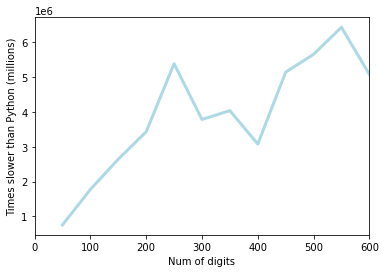

In [12]:
# Now plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_1, color='lightblue', linewidth=3)
plt.xlim(0, top)
plt.xlabel('Num of digits')
plt.ylabel('Times slower than Python (millions)')
plt.show()

#### Notes on comparison
In fact, our implementation is millions of times slower, partly due to heavy, non-optimal use of class instances in the multiply implementation. This will be refactored below. At the moment it is 5 million times slower than Python.

It is growing a little fast, although starts to improve relatively to Python over 500 digits. The test will be run again once the subtract() has been implemented, which should show an improvement with 25% less recursive calls. 

## Subtract() and negative numbers
Implementing subtract also means support for negative numbers. Once subtract is implemented, retest the multiplication mechanism as it will use the Karatsuba version when it detects a subtract function. (Note, updated to remove the check, as this is very slow. Instead, only use the Karatsuba version.)

### Negative number support
Considerations:
- implement as a 'negative' Boolean value
- init() needs to detect this for:
    - string input
    - integer input
    - direct flag when passing in arguments, which will combine with:
    - np_array -> the negative flag will be passed in addition
- multiply() -> two signs the same give a positive, two signs different give a negative, so:
    - we will mark this as a private function, \_multiply() and ignore sign there
    - we can then deal with the sign in the * operator handler
- add() -> adding a negative number can be passed to subtract()
- subtract() -> similarly, subtracting a negative number can be passed to add
- \__str\__() needs to print this

In [13]:
import numpy as np

# Reimplement the class to support subtraction and negative numbers
class NewBaseInteger:
    
    def __init__ (self, x, base=10, negative=False, store=np.int16):
        self._base = base
        self._negative = negative
        self._store = store
        if isinstance(x,(np.ndarray,)):
            self._number = x.copy()
            # In case we copy a zero-length array, add one digit (a zero)
            # This was an error found during testing with random numbers (speed test)
            if len(x) < 1:
                self._number = np.zeros(1, dtype=self._store)
            
        elif isinstance(x,(np.int16,np.int32,np.int64,int)):
            if x < 0:
                x = -x
                self._negative = True
            
            first = True
            if base>100:
                self._store=np.int64
            while first or x >= self._base:
                if first:
                    self._number = np.asarray((x % self._base,),dtype=self._store)
                    first = False
                else:
                    self._number[-1] = x % self._base
                    x //= self._base
                    self._number = np.append(self._number, [x])
        else:
            if x[0] == '-':
                self._negative = True
                x = x.replace('-','')
            if len(x) < 1:
                self._number = np.zeros(1, dtype=self._store)
            elif (base <= 10): # string assumed!
                self._number = np.array(list(map(int,reversed(x))), dtype=self._store)
            else: # could have characters in there.
                self._number = np.array(list(map(lambda x: (ord(x) - 48) if 48 <=ord(x)<=57
                                                 else ord(x)-65+10,reversed(x.upper()))),
                                        dtype=self._store)

        # Calculate any carryovers
        if len(self._number) > 0:
            self._number, self._negative = self.propogate_carryovers(self._number,base,self._negative)
        else:
            print ('empty init', self._number, base, x)
            raise Exception("Zero length")

        # Clean up any leading zeros:
        while len(self._number) > 1 and self._number[-1] == 0:
            self._number = np.delete(self._number, -1)
        # And a sanity check that all digits are less than the base number
        assert (self._number[self._number[:] >= base].sum() == 0), "Overflow - digit out of range."

    def __str__ (self):
        if (self._base <= 10):
            return ('-' if self._negative else '') + ''.join(map(str,reversed(self._number.tolist())))
        elif (self._base <= 36):
            return ('-' if self._negative else '') + ''.join(map(lambda x: str(x) if x < 10
                                                                 else chr(65+x-10),
                                                                 reversed(self._number.tolist())))
        elif (self._base in [100,1_000,10_000,1_00_000,1_000_000, 10_000_000,100_000_000,1_000_000_000]):
            result = ('-' if self._negative else '')
            result += str(self._number[-1])
            if len(self._number > 1):
                num = 0
                b = self._base
                while (b > 1):
                    num += 1
                    b //= 10
                result += ''.join([str(x).zfill(num) for x in self._number[-2::-1]])
            return result
        else:
            return ('-' if self._negative else '') + ('|'.join(self._number))

    def get_longer_shorter(self,x,y):
        if len(x)>len(y):
            return x,y
        return y,x

    def propogate_carryovers(self, result, base, negative):
        # Calculate any carryovers
        for digit in range(0,len(result)-1):
            # note, if we come here after subtraction, some digits may be negative
            # the calculation still works, as the // returns a negative, and
            # the % correctly gives the remainder from the carryover number
            result[digit+1] += result[digit]//base
            result[digit] %= self._base
            #print (result[digit],result[digit+1])

        #print(result, self._base)
        if result[-1] < 0:
            result[-2] = result[-1] % self._base
            result[-1] = 0
            negative = not negative
        while result[-1]>=self._base:
            result = np.append(result, [result[-1]//self._base])
            result[-2] %= self._base
            #print (result[-1],result[-2])
            
        return result, negative

    def shift (self, shift_num):
        result = NewBaseInteger(self._number,self._base,self._negative)
        if shift_num == 0:
            return result
        elif shift_num > 0:
            result._number = np.append(np.zeros(shift_num, dtype=self._store),result._number)
        elif len(result._number) + shift_num > 0:
            result._number = np.delete(result._number,range(0,-shift_num))
        else:
            return NewBaseInteger(0,self._base)
        return result

    def get_bigger_smaller(self,x,y):
        if (len(x) < len (y)):
            #assert(y[-1] != 0)
            return y,x
        if (len(x) == len (y)):
            for i in range (-1,-len(x)-1,-1):
                #print(f'{i}: x[i] = {x[i]}, y[i] = {y[i]}')
                if x[i] < y[i]:
                    return y,x
                    break
                elif x[i] > y[i]:
                    break
        else:
            pass
            #assert(x[-1] != 0)
        return x,y  
    
    def add (self, other):
        # Logic for adding:
        # If the signs are the same add the two numbers.
        # If the signs are different, subtract the smaller and
        # set the sign to the same as the bigger number's sign.

        bigger,smaller=self.get_bigger_smaller(self._number,other._number)
        # Add the digits
        result = 0
        if self._negative == other._negative:
            result = bigger [:len(smaller)] + smaller[:]
        else:
            result = bigger [:len(smaller)] - smaller[:]
            
        result = np.append(result, bigger[len(smaller):])

        # Calculate any carryovers
        result, negative = self.propogate_carryovers(result,
                                                     self._base,
                                                     self._negative if self._number is bigger else other._negative)
            
        return NewBaseInteger(result, self._base, negative)

    def subtract (self, other):
        # Logic for subtracting:
        # Change the sign on the second number (being subtracted).
        # Proceed as for addition - so we call the add() function.
        return self.add(NewBaseInteger(other._number,other._base, not other._negative))

    def _multiply(self, other, negative):
        longer,shorter=self.get_longer_shorter(self._number,other._number)
        # If one is single digit, this is the base case:
        if len(shorter) == 1:
            return NewBaseInteger(longer[:] * shorter[0],self._base, negative)

        # Split the digits into two halves:
        m = len(longer) >> 1 # divide by 2
        b = NewBaseInteger(longer[:m],self._base)
        a = NewBaseInteger(longer[m:],self._base)
        d = NewBaseInteger(shorter[:m],self._base)
        c = NewBaseInteger(shorter[m:],self._base)

        #print(a._number,b._number,c._number,d._number)
        z2 = a._multiply(c, negative)
        z0 = b._multiply(d, negative)
        z1 = (a.add(b))._multiply(c.add(d), negative)

        return z2.shift(m << 1)+(z1-z2-z0).shift(m)+z0
        
    def __add__(self, other):
        return self.add(other)
    def __mul__(self, other):
        return self._multiply(other, (self._negative != other._negative))
    def __sub__(self, other):
        return self.subtract(other)

In [14]:
x = NewBaseInteger('1000')
y = NewBaseInteger('999')

print (x*y)

999000


### Testing
Again at this stage, new test cases were written to test the new negative/subtraction functionality. These were run, along with the other tests as unit/regression tests, and bugs elimiated. See the [bigbaseinteger.py file](), which includes the unit tests. Again, we will skip these here.

## Speed with Karatsuba
Now that we have implemented subtract, the \_multiply() function will automatically use this to reduced the number of recurive calls. Test if it makes a difference:

In [15]:
def get_base_integer(digits, base=10, negative=False, store=np.int16):
    return NewBaseInteger(digits,base) # USING KARATSUBA
step = 50
top = 600
results_karatsuba = do_speed_test(step, top, False, 10, store=store)


Number Length: 50
407 ns ± 63 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
186 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 50: Python is 502,643 times faster.

Number Length: 100
401 ns ± 49.1 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
441 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 100: Python is 1,192,815 times faster.

Number Length: 150
487 ns ± 38.1 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
808 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 150: Python is 1,719,248 times faster.

Number Length: 200
689 ns ± 41.6 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 200: Python is 1,844,433 times faster.

Number Length: 250
920 ns ± 49.9 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.72 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 250: Python

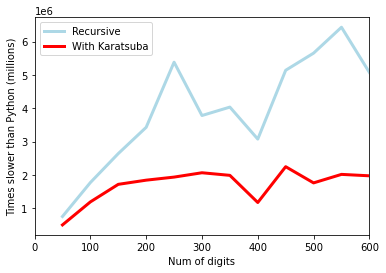

In [16]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_1, color='lightblue', linewidth=3, label='Recursive')
plt.plot(range (step, top+step, step), results_karatsuba, color='red', linewidth=3, label='With Karatsuba')
plt.xlim(0, top)
plt.xlabel('Num of digits')
plt.ylabel('Times slower than Python (millions)')
plt.legend()
plt.show()

#### Notes on comparison
Certainly the Karatsuba implementation is an improvement with less recursive calls.

## Refactoring to improve performance
There are a lot of the base integer objects instantiated each time we go around the loops. Instead, we will refactor and use the numpy arrays directly. This is a little like Python does using underlying integer arithmatic in C.

In [17]:
import numpy as np

# Reimplement the class
class NewBaseInteger2:
    
    def __init__ (self, x, base=10, negative=False, store=np.int16):
        self._base = base
        self._negative = negative
        self._store = store
        if isinstance(x,(np.ndarray,)):
            self._number = x.copy()
            # In case we copy a zero-length array, add one digit (a zero)
            # This was an error found during testing with random numbers (speed test)
            if len(x) < 1:
                self._number = np.zeros(1, dtype=self._store)
            
        elif isinstance(x,(np.int16,np.int32,np.int64,int)):
            if x < 0:
                x = -x
                self._negative = True
            
            first = True
            while first or x >= self._base:
                if first:
                    self._number = np.asarray((x % self._base,),dtype=self._store)
                    first = False
                else:
                    self._number[-1] = x % self._base
                    x //= self._base
                    self._number = np.append(self._number, [x])
        else:
            if x[0] == '-':
                self._negative = True
                x = x.replace('-','')
            if len(x) < 1:
                self._number = np.zeros(1, dtype=self._store)
            elif (base <= 10): # string assumed!
                self._number = np.array(list(map(int,reversed(x))), dtype=self._store)
            else: # could have characters in there.
                self._number = np.array(list(map(lambda x: (ord(x) - 48) if 48 <=ord(x)<=57
                                                 else ord(x)-65+10,reversed(x.upper()))),
                                        dtype=self._store)

        # Calculate any carryovers
        if len(self._number) > 0:
            self._number, self._negative = self.propogate_carryovers(self._number,base,self._negative)
        else:
            print ('empty init', self._number, base, x)
            raise Exception("Zero length")

        # Clean up any leading zeros:
        while len(self._number) > 1 and self._number[-1] == 0:
            self._number = np.delete(self._number, -1)
        # And a sanity check that all digits are less than the base number
        assert (self._number[self._number[:] >= base].sum() == 0), "Overflow - digit out of range."

    def __str__ (self):
        if (self._base <= 10):
            return ('-' if self._negative else '') + ''.join(map(str,reversed(self._number.tolist())))
        elif (self._base <= 36):
            return ('-' if self._negative else '') + ''.join(map(lambda x: str(x) if x < 10
                                                                 else chr(65+x-10),
                                                                 reversed(self._number.tolist())))
        elif self._base in (100 ,1_000, 10_000, 1_00_000, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000):
            result = ('-' if self._negative else '')
            result += str(self._number[-1])
            if len(self._number > 1):
                num = 0
                b = self._base
                while (b > 1):
                    num += 1
                    b //= 10
                result += ''.join([str(x).zfill(num) for x in self._number[-2::-1]])
            return result
        else:
            return ('-' if self._negative else '') + ('|'.join(self._number))

    def get_bigger_smaller(self,x,y):
        if (len(x) < len (y)):
            #assert(y[-1] != 0)
            return y,x
        if (len(x) == len (y)):
            for i in range (-1,-len(x)-1,-1):
                #print(f'{i}: x[i] = {x[i]}, y[i] = {y[i]}')
                if x[i] < y[i]:
                    return y,x
                    break
                elif x[i] > y[i]:
                    break
        else:
            pass
            #assert(x[-1] != 0)
        return x,y       

    def propogate_carryovers(self, result, base, negative):
        # Calculate any carryovers
        for digit in range(0,len(result)-1):
            # note, if we come here after subtraction, some digits may be negative
            # the calculation still works, as the // returns a negative, and
            # the % correctly gives the remainder from the carryover number
            result[digit+1] += result[digit]//base
            result[digit] %= self._base
            #print (result[digit],result[digit+1])

        # Anything to fix with the highest digit?
        if len(result):
            # Is it negative? Convert to a positive and change the sign.
            if result[-1] < 0:
                if len(result) > 1:
                    result[-2] = result[-1] % self._base
                    result[-1] = 0
                else:
                    result[-1] %= self._base
                negative = not negative
            
            # Is there carry over needed to even higher digits?
            while result[-1]>=self._base:
                result = np.append(result, [result[-1]//self._base])
                result[-2] %= self._base
                
            return result, negative
        else:
            # It's zero if empty. Let's make sure it looks right:
            return np.zeros(1, dtype=self._store), False

    def shift (self, shift_num):
        result = NewBaseInteger2(self._number,self._base,self._negative)
        if shift_num == 0:
            return result
        elif shift_num > 0:
            result._number = np.append(np.zeros(shift_num, dtype=self._store),result._number)
        elif len(result._number) + shift_num > 0:
            result._number = np.delete(result._number,range(0,-shift_num))
        else:
            return NewBaseInteger2(0,self._base)
        return result    

    def __add__(self, other):
        result, neg = self._add_numbers(self._number, self._negative, other._number, other._negative)
        return NewBaseInteger2(result, self._base, neg, self._store)
    

    def __mul__(self, other):
        result, neg = self._multiply_numbers(self._number.copy(), other._number.copy())
        return NewBaseInteger2(result, self._base,
                               neg | (self._negative != other._negative))
    def __sub__(self, other):
        result, neg = self._add_numbers(self._number, self._negative, other._number, not other._negative)
        return NewBaseInteger2(result, self._base, neg, self._store)

    def _add_numbers(self, n1, neg1, n2, neg2):
        # Make a copy (or it has side-effects elsewhere)
        # Take the longer one, so that we fit all the numbers in
        bigger, smaller = self.get_bigger_smaller(n1,n2)
        overlap = len(smaller)
        result = bigger.copy()
        
        # numbers are little endian, so overlap is at the front:
        if neg1 == neg2:
            result[:overlap] = bigger[:overlap] + smaller
        else:
            result[:overlap] = bigger[:overlap] - smaller
            
        result, neg = self.propogate_carryovers(result, self._base, neg1 if n1 is bigger else neg2)

        return np.trim_zeros(result,'b'), neg

    def _subtract_numbers(self, n1, neg1, n2, neg2):
        return self._add_numbers(n1, neg1, n2, not neg2)

    def _multiply_numbers(self, first, second):
        # If one is single digit, this is the base case:
        lenfirst = len(first)
        lensecond = len(second)
        if lenfirst < lensecond:
            first, second = second,first
            lenfirst, lensecond = lensecond, lenfirst
        if lenfirst == 1:
            return self.propogate_carryovers(second[:] * first[0], self._base, False)
            #return result, False
        if lensecond == 1:
            return self.propogate_carryovers(first[:] * second[0], self._base, False)
            #return result, False
        if not lenfirst or not lensecond:
            return np.zeros(1, dtype=self._store), False

        # Split the digits into two halves:
        m = lenfirst >> 1 # divide by 2
        b = np.trim_zeros(first[:m], 'b')
        a = first[m:]
        d = np.trim_zeros(second[:m], 'b')
        c = second[m:]

        z2, z2neg = self._multiply_numbers(a, c)
        z0, z0neg = self._multiply_numbers(b, d)
        z1, z1neg = self._multiply_numbers(self._add_numbers(a, False, b, False)[0], self._add_numbers(c, False, d, False)[0])

        # Do the additions needed. A little more longwinded that previously,
        # as we have to separate them out with the new implementation.
        z2z0, z2z0neg = self._add_numbers(z2, z1neg, z0, z0neg)
        # This subtraction is done by changing the sign and adding:
        zmiddle, zmneg = self._add_numbers(z1, z1neg, z2z0, not z2z0neg)
        zmiddle = np.append(np.zeros(m, dtype=self._store), zmiddle)

        zends, zendsneg = self._add_numbers(np.append(np.zeros(m << 1, dtype=self._store), z2), z2neg,
                                            z0, z0neg)
        return self._add_numbers(zends, zendsneg, zmiddle, zmneg)
    
        #return z2.shift(2*m)+(z1-z2-z0).shift(m)+z0


Unit tests were run at this point but not shown here.
Let's check the speed:


In [18]:
step = 50
top = 600
def get_base_integer(digits, base=10, negative=False, store=np.int16):
    return NewBaseInteger2(digits,base) # USING KARATSUBA
results_karatsuba_refactor = do_speed_test(step, top)


Number Length: 50
176 ns ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 50: Python is 291,691 times faster.

Number Length: 100
284 ns ± 39.2 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
127 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 100: Python is 487,366 times faster.

Number Length: 150
396 ns ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
256 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 150: Python is 674,417 times faster.

Number Length: 200
547 ns ± 38.1 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
398 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 200: Python is 750,825 times faster.

Number Length: 250
753 ns ± 36.1 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
551 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 250: Python is

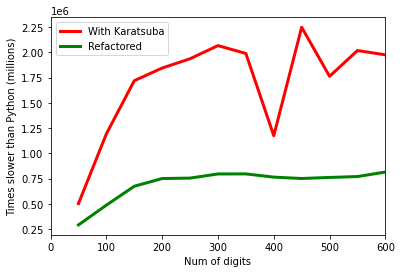

In [19]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_karatsuba, color='red', linewidth=3, label='With Karatsuba')
plt.plot(range (step, top+step, step), results_karatsuba_refactor, color='green', linewidth=3, label='Refactored')
plt.xlim(0, top)
plt.legend()
plt.xlabel('Num of digits')
plt.ylabel('Times slower than Python (millions)')
plt.show()

#### Comments on refactoring

This has improved things by a factor of 3 times. Still slow, but better.

## Improving further
The underlying Python implementation uses integer multiplication for shorter numbers (up to arounf 6 or 7 digits long). This is because we can use built-in integers up to 64 bits, which gives us numbers up to 9,223,372,036,854,775,807 - before it runs out of bits and get a binary overflow, where the integers turn negative.

We can implement this using our current class and setting the base to something big - like a million. Now, this is going to be cheating a little, as we're using the Python integer implementation to compare with itself, at least at shorter numbers. But the principle is there, at least.

I will tweak the do_speed_test to create these big base numbers, 

I'll need change the NewBaseInteger implementation, as this uses numpy.int16, which will run out of bits quickly. Instead, we'll default to numpy.int16, and if the base goes above 100, switch to np.int64. That should allow us to pass in digits in blocks of 6 - or 'base 1 million'.

In [20]:
def get_base_integer(digits, base=1000, negative=False, store=np.int16):
    return NewBaseInteger2(digits,base, store=store) # USING KARATSUBA + grouping in thousands

# Generate numbers with 50, 100, 150, 200, 250 and 300 digits
def do_speed_test(step, top, check_products=False, base=100, title=''):
    if len(title):
        print(title)
        print(len(title)*'=')
    store = np.int16
    if base > 100:
        store = np.int64

    results = []
    num_dig_base = 0
    b = base
    while (b > 1):
        num_dig_base += 1
        b //= 10
    for num_digits in range (step, top+step, step):
        print(f'Number Length: {num_digits}')
        # Create a set of random digits of the required length:
        digits = np.random.randint(0,9,num_digits)
        py_num = 0

        # The BaseInteger class can initialise from an np_array, as it uses these
        # internally. But they are stored 'big endian' (lowest digit first).
        big_base_digits = []
        if base > 10:
            for slice in range(0,len(digits)-num_dig_base,num_dig_base):
                temp_num = 0
                for x in range(num_dig_base):
                    temp_num *= 10 # Shift up one place
                    temp_num += int(digits[slice+x]) # Add the next digit
                big_base_digits.append(temp_num)
        else:
            big_base_digits = digits

        # print(big_base_digits)
        bi_num = get_base_integer(np.asarray(big_base_digits,dtype=store), base, store)
        # print(bi_num, bi_num._number, bi_num._base)
        
        # Turn these into a python integer, and we do this 'little endian':
        py_num = int(str(bi_num))
        #print("> Test number:", py_num)

        # Check we have the same numbers. Note the casts to get an integer.
        if py_num - int(str(bi_num)) != 0:
            print("> Error - numbers are different.")

        # Use the timeit magic and note the result
        py_result = %timeit -n10 -o (py_num*py_num)
        bi_result = %timeit -n1 -r1 -o (bi_num * get_base_integer(digits))
        if check_products:
            if py_num*py_num - int(str(bi_num * get_base_integer(digits))) != 0:
                print("> Error - products are different.")
                print(py_num*py_num)
                print(bi_num * get_base_integer(np.asarray(big_base_digits,dtype=store), base))
            else:
                print("> OK: products match.")

        # Print out the difference in speed and store in our results array.
        print(f'Number Length {num_digits}: Python is {bi_result.best/py_result.best:,.0f} times faster.\n')
        results.append(bi_result.best/py_result.best)
    return results

Now let's test and plot the results:

In [21]:
results_1000 = do_speed_test(step,top,False,1_000_000, title='Karatsuba using base 1,000,000')

Karatsuba using base 1,000,000
Number Length: 50
181 ns ± 36.4 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
14 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 50: Python is 87,265 times faster.

Number Length: 100
266 ns ± 26.6 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 100: Python is 146,191 times faster.

Number Length: 150
361 ns ± 36.4 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
79.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 150: Python is 233,198 times faster.

Number Length: 200
540 ns ± 45 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
122 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 200: Python is 234,241 times faster.

Number Length: 250
747 ns ± 38.1 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
142 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


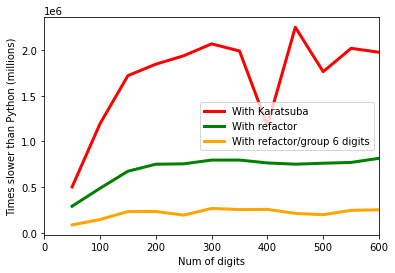

In [22]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_karatsuba, color='red', linewidth=3, label='With Karatsuba')
plt.plot(range (step, top+step, step), results_karatsuba_refactor, color='green', linewidth=3, label='With refactor')
plt.plot(range (step, top+step, step), results_1000, color='orange', linewidth=3, label='With refactor/group 6 digits')
plt.xlim(0, top)
plt.xlabel('Num of digits')
plt.ylabel('Times slower than Python (millions)')
plt.legend()
plt.show()

#### Comments
The updates have dropped the time to 2 seconds for the longest number (600 digits). Three times better than base 10 and now only 200 thousand times slower than Python. 

## Summary
The integer class has been implemented using the Karatsuba algorithm. It has been shown to make a good improvement on other general algorithms. This particular implentation isn't blazingly fast, however the aim was only to explore the algorithm.

The code that can handle multiplication (and add/subtract) _in any base_, from binary through decimal to 'base 1,000,000', although above that we would risk a bit overflow on the 64-bit integer that we use in numpy to support this. The class can also handle long integers - 10s of thousands of digits or 'limbs' long.

The final version of the class can be also found in [bigbaseinteger.py]() file, which includes unit tests.

### Further developments
Some addtional areas that could be implemented:
- Division (with remainders)
- Powers (positive integers)
- Further tweaks and performance improvements could be made and there has been a lot of research into this.
This implementation is written in Python it would still not match the speed and memory conservation that is achievable in C, for example.

### Next algorithms
The next step in this exploration is implementing [Multiplication wih Fast Fourier Transform]() and the related Number Theoretic Transform which have both been used to improve the speed of big integer multiplication. These are the basis of further speed improvements, widely used in modern cryptography (e.g. encoding and decoding web traffic over HTTPS).